In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from utils import plot_images, train_valid_split
from metric import apk, mapk
import lightgbm as lgb

import faiss
import psutil
from lightfm import LightFM
from scipy import sparse
import catboost

In [2]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")
transactions['day'] = (transactions['t_dat'].max() - transactions['t_dat']).dt.days


In [3]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            prefix: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        tr = transactions.query(
            "user in @target_users and @week_start <= week <= @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)

        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_week.merge(gr_volume, on=['user', 'item'])
        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank']].rename(
            columns={'week_rank': f'{prefix}_week_rank', 'volume_rank': f'{prefix}_volume_rank'})
        return candidates

    def create_candidates_popular(
            prefix: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        NUM_POPULAR_ITEMS = 12
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:NUM_POPULAR_ITEMS]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(NUM_POPULAR_ITEMS),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{prefix}_rank'})
        return candidates

    def create_candidates_cooc(
            prefix: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_end: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week == @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query(
            "item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_sz = tr.groupby('item').size().reset_index(name='tot')
        gr_cnt = tr.groupby(['item', 'item_with']).size().reset_index(name='cnt')
        item2item = gr_cnt.merge(gr_sz, on='item')
        item2item['ratio'] = item2item['cnt'] / item2item['tot']
        item2item = item2item.query("ratio >= 0.030730").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if c not in ['user', 'item', 'week']]
        replace = {c: f"{prefix}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(item2item, on='item').drop(
            ['item', 'cnt'], axis=1).rename(columns={'item_with': 'item'}).rename(columns=replace)
        candidates = candidates.rename(columns={'ratio': f'{prefix}_ratio', 'tot': f'{prefix}_tot'})
        return candidates

    def create_candidates_same_product_code(
            prefix: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename(
            {'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if c not in ['user', 'item', 'week']]
        replace = {c: f"{prefix}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(
            item2item,
            on='item').drop(
            'item',
            axis=1).rename(
            columns={
                'item_with': 'item'}).rename(
                    columns=replace)
        return candidates

    def create_candidates_same_category_top(
            strategy: str,
            transactions: pd.DataFrame,
            users: pd.DataFrame,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame,
            week_start: int,
            week_end: int,
            category: str,
            ) -> pd.DataFrame:
        users = users.copy()
        users['age_segment'] = users['age'] // 10
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(items[['item', category]], on='item').merge(users[['user', 'age_segment']], on='user')
        category_popular_items = tr.groupby(['item', 'age_segment', category]).size().reset_index(name='cnt')
        category_popular_items['segment_rank'] = category_popular_items.groupby(category)['cnt'].rank(ascending=False, method='dense')
        category_popular_items = category_popular_items.query('segment_rank <= 3')

        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = (base_candidates
                      .merge(users[['user', 'age_segment']], on='user')
                      .merge(items[['item', category]], on='item')
                      .drop('item', axis=1)
                      .merge(category_popular_items, on=['age_segment', category])
                      .rename(columns=replace))[['user', 'item', 'segment_rank']]

        # candidates['strategy'] = strategy
        return candidates

    candidates = [
        create_candidates_repurchase('repurchase', transactions, target_users, week, week + 40),
        create_candidates_popular('pop', transactions, target_users, week, week),
    ]
    cat = 'product_type_no'
    candidates_same_category_top = create_candidates_same_category_top(f'same_{cat}', transactions, users, items, candidates[0], week, week, cat)
    candidates.append(candidates_same_category_top)
    candidates.append(create_candidates_cooc('cooc', transactions, week, week + 12, candidates[0]))
    candidates.append(create_candidates_same_product_code('same_product_code', items, candidates[0]))
    
    volumes = np.array([len(c) for c in candidates])
    print(volumes, volumes / np.sum(volumes))

    return pd.concat(candidates).reset_index(drop=True)


In [4]:
# valid: week=1
# train: week=2..1+num_train_weeks
num_train_weeks = 3
candidates = []
for week in range(1, 2+num_train_weeks):
    target_users = transactions[transactions['week'] == week]['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

[1443705  827808 1874926 3449125 8777527] [0.08817547 0.05055905 0.11451265 0.21065815 0.53609468]
[1560164  864228 2190118 4908354 9468051] [0.08215318 0.04550744 0.11532451 0.258458   0.49855686]
[1605657  909864 2106867 5007577 9934564] [0.0820698  0.0465058  0.1076881  0.25595183 0.50778447]
[ 1684869   963036  2249793  4950146 10432776] [0.08307779 0.04748553 0.11093315 0.24408258 0.51442096]


In [5]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidates
        (user, item, strategy, score)

    Return
    ------
    (user, item, y, ...)
    """
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)
    remaining_positives = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives / original_positives
    print(f"Recall: {recall}")
    return labels

In [6]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], 1+idx)


Recall: 0.10469849528372512
Recall: 0.10414637356851389
Recall: 0.10465233498828096
Recall: 0.09782029376263854


In [7]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


def calc_query_groups(labels):
    """
    userでソートして、データセットに与える必要があるグループを計算する
    user, y
    """
    df = labels.sort_values(by='user').reset_index(drop=True)
    group = get_query_group(df)
    return df, group


In [8]:
for idx in range(len(candidates)):
    candidates[idx]['week'] = 1+idx

valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 16373091 -> 5704122
drop trivial queries: 18990915 -> 6823387
drop trivial queries: 19564529 -> 7000798
drop trivial queries: 20280620 -> 6936689


In [9]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    week: これを含めた以前の情報は使って良い
    """
    n_original = len(candidates)
    df = candidates.copy()

    # user static features
    user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
    df = df.merge(users[['user'] + user_features], on='user')

    # item static features
    item_features = [c for c in items.columns if c.endswith('idx')]
    df = df.merge(items[['item'] + item_features], on='item')

    # user dynamic features (transactions)
    num_weeks = 8
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='user', how='left')
    
    # user dynamic features (product_code ratio, short term)
    num_weeks = 3
    week_end = week + num_weeks
    cat = 'product_type_no_idx'
    tmp = transactions.query("@week <= week < @week_end").merge(items[['item', cat]], on='item').groupby(['user', cat]).size().reset_index(name=f'user_{cat}_cnt_short_term')
    tmp['user_cnt'] = tmp.groupby('user')[f'user_{cat}_cnt_short_term'].sum()
    tmp[f'user_{cat}_rank_short_term'] = tmp.groupby(f'user_{cat}_cnt_short_term')[cat].rank(ascending=False, method='dense')
    tmp[f'user_{cat}_ratio_short_term'] = tmp[f'user_{cat}_cnt_short_term'] / tmp['user_cnt']
    del tmp['user_cnt']
    df = df.merge(tmp, on=['user', cat], how='left')

    # user dynamic features (product_code ratio, long term)
    num_weeks = 8
    week_end = week + num_weeks
    cat = 'product_type_no_idx'
    tmp = transactions.query("@week <= week < @week_end").merge(items[['item', cat]], on='item').groupby(['user', cat]).size().reset_index(name=f'user_{cat}_cnt_long_term')
    tmp['user_cnt'] = tmp.groupby('user')[f'user_{cat}_cnt_long_term'].sum()
    tmp[f'user_{cat}_rank_long_term'] = tmp.groupby(f'user_{cat}_cnt_long_term')[cat].rank(ascending=False, method='dense')
    tmp[f'user_{cat}_ratio_long_term'] = tmp[f'user_{cat}_cnt_long_term'] / tmp['user_cnt']
    del tmp['user_cnt']
    df = df.merge(tmp, on=['user', cat], how='left')

    # item dynamic features (transactions)
    num_weeks = 8
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item price diff features (transactions)
    week_end = week + 2
    tmp = transactions.query("@week <= week < @week_end").groupby(['item', 'week'])[['price']].agg(['mean', 'std'])
    tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    tmp_this_week = (tmp
                     .query('week==@week')[['item_price_mean', 'item_price_std']]
                     .rename(columns={'item_price_mean': 'item_price_mean_this_week', 'item_price_std': 'item_price_std_this_week'}))
    tmp_last_week = (tmp
                     .query('week==@week+1')[['item_price_mean', 'item_price_std']]
                     .rename(columns={'item_price_mean': 'item_price_mean_last_week', 'item_price_std': 'item_price_std_last_week'}))
    tmp2 = tmp_this_week.merge(tmp_last_week, on='item')
    tmp2['item_price_mean_diff'] = tmp2['item_price_mean_this_week'] - tmp2['item_price_mean_last_week']
    tmp2['item_price_std_ratio'] = tmp2['item_price_std_this_week'] / tmp2['item_price_std_last_week']
    df = df.merge(tmp2, on='item', how='left')
    
    # item dynamic features (user features)
    num_weeks = 8
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
    tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
    tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item dynamic features (segment rank)
    num_weeks = 2
    cat = 'product_type_no_idx'
    week_end = week + num_weeks
    users_tmp = users.copy()
    users_tmp['age_segment'] = users_tmp['age'] // 3
    tmp = (transactions
           .query("@week <= week < @week_end")
           .merge(users_tmp[['user', 'age_segment']], on='user')
           .merge(items[['item', cat]], on='item'))
    tmp = tmp.groupby(['age_segment', cat, 'item']).size().reset_index(name='cnt')
    tmp['rank'] = tmp.groupby(['age_segment', cat])['cnt'].rank(ascending=False, method='dense')
    tmp = tmp[['age_segment', 'item', 'rank', 'cnt']].set_index(['age_segment', 'item'])
    tmp.columns = [f'{cat}_segment_{a}' for a in tmp.columns.to_flat_index()]
    df = df.merge(users_tmp[['user', 'age_segment']], on='user').merge(tmp, on=['age_segment', 'item'], how='left')
    
    # item dynamic features (repurchase num)
    num_weeks = 4
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end")
    tmp = tmp.groupby(['item', 'user']).size().reset_index(name='cnt')
    tmp = tmp.groupby('item')['cnt'].mean().reset_index(name='item_repurchase_volume')
    df = df.merge(tmp, on='item', how='left')
    
    # item freshness features
    tmp = transactions.query("@week <= week").groupby('item')['week'].min().reset_index(name='item_week_min')
    tmp['item_week_min'] -= week
    df = df.merge(tmp, on='item', how='left')
    
    # item volume features
    num_weeks = 1
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
    df = df.merge(tmp, on='item', how='left')

    # # user freshness features
    # tmp = transactions.query("@week <= week").groupby('user')['week'].min().reset_index(name='user_week_min')
    # tmp['user_week_min'] -= week
    # df = df.merge(tmp, on='user', how='left')

    # # user volume features
    # num_weeks = 1
    # week_end = week + num_weeks
    # tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
    # df = df.merge(tmp, on='user', how='left')

    # user-item freshness features
    tmp = transactions.query("@week <= week").groupby(['user', 'item'])['week'].min().reset_index(name='user_item_week_min')
    tmp['user_item_week_min'] -= week
    df = df.merge(tmp, on=['item', 'user'], how='left')

    # user-item volume features
    num_weeks = 1
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
    df = df.merge(tmp, on=['user', 'item'], how='left')
    
    assert len(df) == n_original
    return df


valid_all = attach_features(transactions, users, items, valid_all, 2)
for idx in range(len(candidates)):
    candidates[idx] = attach_features(transactions, users, items, candidates[idx], 2+idx)

In [10]:
datasets = []
for idx in range(len(candidates)):
    datasets.append(calc_query_groups(candidates[idx]))

valid, group_valid = datasets[0]

def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx][0] for idx in range(begin, begin+num)])
    group_train = []
    for idx in range(begin, begin+num):
        group_train += datasets[idx][1]
    return train, group_train

train, group_train = concat_train(datasets, 1, num_train_weeks)

In [11]:
feature_columns = [c for c in valid.columns if c not in ['y', 'week', 'group']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'segment_rank', 'cooc_repurchase_week_rank', 'cooc_repurchase_volume_rank', 'cooc_tot', 'cooc_ratio', 'same_product_code_repurchase_week_rank', 'same_product_code_repurchase_volume_rank', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'user_product_type_no_idx_cnt_short_term', 'user_product_type_no_idx_rank_short_term', 'user_product_type_no_idx_ratio_short_term', 'user_product_type_no_idx_cnt_long_term', 'user_product_type_no_idx_rank_long_term', 'user_product_type_no_idx_ratio_long_term', 'user_product_type_no_

In [12]:
train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

In [13]:
params = {
    'objective': 'xendcg',
    'boosting_type': 'gbdt',
    'learning_rate': 1e-6,
    'num_leaves': 511,
    'min_data_in_leaf': 500,
    'metric': 'map',
    'eval_at': 12,
}

model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=10000, callbacks=[lgb.early_stopping(100)])


[LightGBM] [Info] Total groups: 52418, total data: 20760874
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.173442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9121
[LightGBM] [Info] Number of data points in the train set: 20760874, number of used features: 59
[LightGBM] [Info] Total groups: 15914, total data: 5704122
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	training's map@12: 0.221547	valid_1's map@12: 0.20675


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

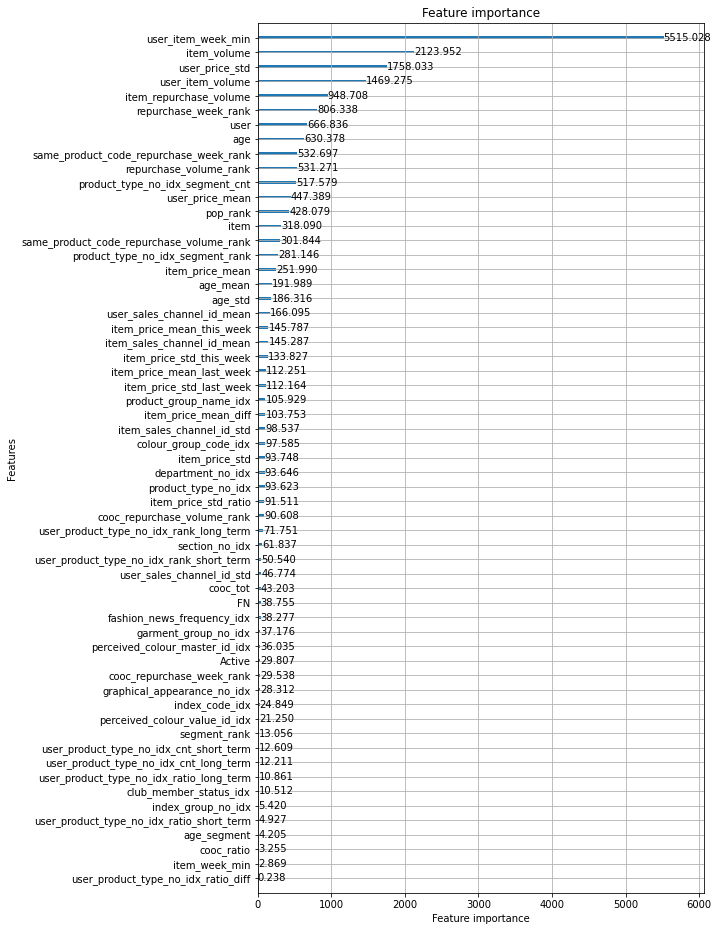

In [14]:
lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

In [15]:
valid_all['pred'] = model.predict(valid_all[feature_columns])
pred = valid_all.groupby(['user', 'item'])['pred'].max().reset_index()


In [16]:
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(
    drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
pred


,user,item
0,80,"[2865, 104045, 3091, 42129, 103108, 67522, 104..."
1,86,"[100228, 33868, 27905, 98606, 102472, 102710, ..."
2,107,"[61303, 61305, 61304, 2219, 13042, 53892, 8465..."
3,117,"[104045, 103108, 3091, 82628, 71107, 67522, 10..."
4,179,"[95216, 104986, 105180, 3510, 3091, 95217, 105..."
...,...,...
68979,1371868,"[93158, 17043, 93157, 104045, 93159, 3091, 463..."
68980,1371871,"[67522, 104045, 104072, 3091, 42626, 103108, 8..."
68981,1371879,"[103668, 103666, 103669, 103665, 103667, 10367..."
68982,1371937,"[59774, 67522, 104045, 59772, 59773, 42626, 59..."


In [17]:
gt = transactions[transactions['week'] == 1].groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)
merged


,user,gt,item
0,80,[28967],"[2865, 104045, 3091, 42129, 103108, 67522, 104..."
1,86,[87371],"[100228, 33868, 27905, 98606, 102472, 102710, ..."
2,107,"[69711, 77256, 33872]","[61303, 61305, 61304, 2219, 13042, 53892, 8465..."
3,117,[97391],"[104045, 103108, 3091, 82628, 71107, 67522, 10..."
4,179,"[102397, 98409, 73, 95784, 103796, 105103, 103...","[95216, 104986, 105180, 3510, 3091, 95217, 105..."
...,...,...,...
68979,1371868,"[97531, 103424]","[93158, 17043, 93157, 104045, 93159, 3091, 463..."
68980,1371871,"[94310, 91533]","[67522, 104045, 104072, 3091, 42626, 103108, 8..."
68981,1371879,"[2118, 84994, 57078, 84991, 101099, 104036, 87...","[103668, 103666, 103669, 103665, 103667, 10367..."
68982,1371937,"[67261, 70640]","[59774, 67522, 104045, 59772, 59773, 42626, 59..."


In [18]:
mapk(merged['gt'], merged['item'])

0.030146470052640147

save result

In [ ]:
model.save_model('./output/lgb.txt')
valid_all.to_pickle('./output/valid_all.pkl')
merged.to_pickle('./output/merged.pkl')

In [ ]:
assert False

submission

In [ ]:
train, group_train = concat_train(datasets, 0, num_train_weeks)

In [ ]:
train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
best_iteration = model.best_iteration
model = lgb.train(params, train_dataset, num_boost_round=best_iteration)
lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

In [ ]:
all_users = users['user'].values
all_users

In [ ]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 1)
    candidates = attach_features(transactions, users, items, candidates, 1)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

In [ ]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [ ]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

In [ ]:
submission.to_csv('submission.csv', index=False)